In [25]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
pd.set_option("display.precision", 15)
import numpy as np
plt.rcParams.update({'font.size': 22})
plt.rcParams['svg.fonttype'] = 'none'
from matplotlib.patches import Rectangle
from functools import reduce

def plot_change_against_sig_weighted(change, signatures, sig_weights,title):


    plt.figure(figsize=(10, 6))

    # Scatter plot
    '''
    for i in range(len(change)):
        plt.scatter(signatures[i], change[i], s=2000*sig_weights[i])
        '''
    plt.scatter(signatures, change, s=2000 * sig_weights)
    #xtick_labels = [sig if w > 0.02 or sig in ['SBS15', 'SBS6'] else '' for sig, w in zip(signatures, sig_weights)]
    xtick_labels = [sig if w > 0.02 else '' for sig, w in zip(signatures, sig_weights)]
    plt.xticks(ticks=range(len(signatures)), labels=xtick_labels, rotation=45)

    #np.array(sig_weights)
    #plt.plot(change, 'ko', markersize=1000 * sig_weights)
    plt.axhline(y=0, linestyle='-')
    plt.xticks(rotation=80, fontsize=13)
    plt.ylabel('$l^g, g \in \mathbf{cancer\ genes, HCLCA-human} $', fontsize=18)
    #plt.ylabel('$Delta^g, g \in \mathbf{cancer\ genes} $', fontsize=14)
    plt.xlabel('Signatures', fontsize=18)
    #plt.title('All sites', fontsize=16)
    plt.title(title, fontsize=20)
    x1,x2,y1,y2 = plt.axis()  
    plt.axis((x1,x2,-0.002,0.005))
    #plt.axis((x1,x2,-0.000015,0.000035))# for hclca-human #dpi=100, bbox_inches='tight'
    #plt.savefig(f'/home/maria/target_size_MRCA/output_graph/syn_syn.svg', format='svg')
    plt.show()

    return


def extract_avg_l_per_sig(file_path, species, cancer_genes_list):
    #looking at current human 
    files_list = glob.glob(f'{file_path}*')
    
    files_list.remove(f'{file_path}M_n_non_syn_muts')

    l_c = []
    l_nc = []
    signature = []

    for l_file in files_list:
        
        l_df = pd.read_csv(l_file, sep=',', header=None, index_col = 0  )
        #l_df = l_df[l_df.index.isin(extract_genes)]
        
        cg = set(cancer_genes_list)                      # faster membership
        mask = l_df.index.isin(cg)

        cancer_l_df = l_df[mask]
        mean_cancer_l = cancer_l_df.mean(numeric_only=True)
        #mean_cancer_l = cancer_l_df.mean(numeric_only=True).item() 
        l_c.append(mean_cancer_l.iat[0])

        non_cancer_l_df = l_df[~mask] 
        mean_non_cancer_l = non_cancer_l_df.mean(numeric_only=True)
        l_nc.append(mean_non_cancer_l.iat[0])

        signature_name = l_file[l_file.rindex('_')+1:]
        #when sig is single digit get issue 
        signature.append(signature_name) 

    #per signature, should only consider the driver cancer genes where signature is present? 
    #dict = {'signature': signature, 'l_c':l_c, 'l_nc': l_nc}
    dict = {'signature': signature, f'l_c_{species}':l_c, f'l_nc_{species}': l_nc}
    df = pd.DataFrame(dict)
    #results = df[~df.signature.isin(artefacts_sigs)]
    #results.sort_values(f'l_c_{species}', ascending=False, inplace=True)
    df.set_index('signature',inplace=True)
    return df

def plot_c_diff_against_nc_diff(c_diff, nc_diff, signatures, sig_weights,title):
    
    # Scatter plot
    plt.scatter(nc_diff, c_diff, s=1000 * sig_weights, color='k', alpha=1)  # 'k' is black
    
    #add line y=x
    plt.plot(nc_diff, nc_diff, linewidth=1, alpha =0.3, label = 'line y=x')

    # Determine plot limits
    y_min = min(c_diff)*1.1
    y_max = max(c_diff)*1.1
    x_min = min(nc_diff)*1.1
    x_max = max(nc_diff)*1.1

    # Add shaded background rectangles
    ax = plt.gca()  # get current axes
    # Bottom-left 
    ax.add_patch(Rectangle((x_min, y_min), 0 - x_min, 0 - y_min, color='red', alpha=0.1,label='c increase in mutability'))
    # Bottom-right 
    ax.add_patch(Rectangle((0, y_min), x_max - 0, 0 - y_min, color='red', alpha=0.1))
    # Top-right (Red)
    ax.add_patch(Rectangle((0, 0), x_max - 0, y_max - 0, color='green', alpha=0.1, label='c decrease in mutability'))
    # Top-left (Yellow)
    ax.add_patch(Rectangle((x_min, 0), 0 - x_min, y_max - 0, color='green', alpha=0.1))

    # Axes lines
    plt.axvline(x=0, linestyle='-', color='black')
    plt.axhline(y=0, linestyle='-', color='black')

    # Labels
    #plt.rcParams['text.usetex'] = True
    plt.xlabel('$\Delta l^g, g \in \mathbf{non\ cancer\ genes}$')
    plt.ylabel('$\Delta l^g, g \in \mathbf{cancer\ genes}$')
    plt.title(title)

    # Signature labels for most impt sigs
    for i, sig in enumerate(signatures):
        if sig_weights[i]>0.02:
            if sig=='SBS10b':
                print(sig)
                print(nc_diff[i])
                print(c_diff[i])
            plt.text(nc_diff[i], c_diff[i], sig[3:], fontsize=12, ha='right', va='bottom', alpha=1)
    #, alpha=0.4+sig_weights[i]*3
    
    #shaing region, x<y<0
    
    # Generate x values from the intersection of y=x and y=0 (i.e., where y = x < 0)
    x_fill = np.linspace(x_min, 0, 500)
    y1 = x_fill       # lower bound: y = x
    y2 = np.zeros_like(x_fill)  # upper bound: y = 0

    # Fill between y = x and y = 0, only where y < 0 and x < y
    plt.fill_between(x_fill, y1, y2, color='yellow', alpha=0.2, label='smaller increase in c mutability than nc')

    # Set axis limits
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(fontsize=12)
    plt.tight_layout()

    plt.show()

    return

def extract_avg_l_per_sig_matched_genes(file_path, species, matched_gene_df, gene_dict):
    cancer_genes_list=matched_gene_df.index.to_list()
    
    files_list = glob.glob(f'{file_path}*')
    files_list.remove(f'{file_path}M_n_non_syn_muts')

    l_c = []
    l_nc = []
    signature = []

    l_df1 = pd.read_csv(files_list[0], sep=',', header=None, index_col = 0)
    l_df1 = l_df1.rename(index=gene_dict)
    all_genes = l_df1.index
    cancer_genes_recon = list(set(cancer_genes_list)&set(all_genes))
    matched_genes = []
    cancer_genes_extract=[]
    for cancer_gene in cancer_genes_recon:
        cancer_df = matched_gene_df.loc[cancer_gene]
        cancer_df = cancer_df[cancer_df['matched_gene'].isin(all_genes)].copy()
        if isinstance(cancer_df, pd.DataFrame) and len(cancer_df) > 1:
            cancer_df.sort_values(by=['distance'],inplace=True)
            #first entry should always be cancer gene itself
            matched_gene = cancer_df['matched_gene'].iloc[1]

            matched_genes.append(matched_gene)
            cancer_genes_extract.append(cancer_gene)
    
    for l_file in files_list:
        l_df = pd.read_csv(l_file, sep=',', header=None, index_col = 0  )
        l_df = l_df.rename(index=gene_dict)
        cancer_l_df = l_df[l_df.index.isin(cancer_genes_extract)]
        mean_cancer_l = cancer_l_df.mean()
        l_c.append(mean_cancer_l.iat[0])
        
        #chossing non cancer genes from best match of df
        non_cancer_l_df = l_df[l_df.index.isin(matched_genes)] 
        mean_non_cancer_l = non_cancer_l_df.mean()
        l_nc.append(mean_non_cancer_l.iat[0])
        
        signature_name =  l_file[l_file.rindex('_')+1:]
        signature.append(signature_name) 

    #per signature, should only consider the driver cancer genes where signature is present? 
    #dict = {'signature': signature, 'l_c':l_c, 'l_nc': l_nc}
    dict = {'signature': signature, f'l_c_{species}':l_c, f'l_nc_{species}': l_nc}
    df = pd.DataFrame(dict)
    #results = df[~df.signature.isin(artefacts_sigs)]
    #results.sort_values(f'l_c_{species}', ascending=False, inplace=True)
    df.set_index('signature',inplace=True)
    return df

def extract_sigs_per_gene(file_path):

    #looking at current human 
    
    files_list = glob.glob(f'{file_path}*')
    unnamed_file = f'{file_path}l_Unnamed: 0'
    if unnamed_file in files_list:
        files_list.remove(unnamed_file)
    files_list.remove(f'{file_path}M_n_non_syn_muts')

    sig_dfs ={}
    for l_file in files_list:
        sig = l_file[l_file.rindex('_')+1:]
        
        l_df_all = pd.read_csv(l_file, sep=',', names=['gene', f'{sig}'], index_col = 0  )
        
        
        sig_dfs[l_file] = l_df_all
    
    merged_df = reduce(lambda left, right: left.join(right, how ='inner'),
                   sig_dfs.values())
    
    return merged_df

def extract_avg_l_per_sig_all_from_gene_list(file_path, species, gene_list):
    #looking at current human 
    files_list = glob.glob(f'{file_path}*')
    unnamed_file = f'{file_path}l_Unnamed: 0'
    if unnamed_file in files_list:
        files_list.remove(f'{file_path}l_Unnamed: 0')
    files_list.remove(f'{file_path}M_n_non_syn_muts')

    l = []
    signature = []

    for l_file in files_list:
        
        l_df = pd.read_csv(l_file, sep=',', header=None, index_col = 0)
        intersect_l_df = l_df[l_df.index.isin(gene_list)]
        
        mean_l = intersect_l_df.mean()
        l.append(mean_l.iat[0])

        signature_name = l_file[l_file.rindex('_')+1:]
        signature.append(signature_name)
         

    #per signature, should only consider the driver cancer genes where signature is present? 
    #dict = {'signature': signature, 'l_c':l_c, 'l_nc': l_nc}
    dict = {'signature': signature, f'l_{species}':l}
    df = pd.DataFrame(dict)
    df.sort_values(f'l_{species}', ascending=False, inplace=True)
    return df

# Extract the dataframes for each species
def extract_df_per_species_gene_subset(species_filepaths, cancer_gene_list, plot, subset_included, name, base_species):
    species_genes_dict = {}
    for species, path in species_filepaths.items():
        l_df = pd.read_csv(f'{path}l_SBS1', sep=',', header=None, index_col = 0)
        species_genes_dict[species] = set(l_df.index)
        
      
    # Get the intersection of all gene lists
    
    common_genes = set.intersection(*map(set, species_genes_dict.values()))
    print(common_genes)
    
    if subset_included ==1:
        common_cancer_genes = set.intersection(common_genes, cancer_gene_list)

    #to extract all genes but those given in the list
    if subset_included ==0:
        common_cancer_genes = common_genes - set(cancer_gene_list)
    
    # Convert back to a list (optional)
    common_cancer_genes = list(common_cancer_genes)
    
    print(common_cancer_genes)
    print(len(common_cancer_genes))

    #extract species df, using same genes for all species
    species_cancer_dfs = {}
    for species, path in species_filepaths.items():
        species_cancer_dfs[species] = extract_avg_l_per_sig_all_from_gene_list(path, f'{species}_{name}',common_cancer_genes)
        
    # Merge all dataframes on 'signature'
    cancer_merged_df = reduce(lambda left, right: left.merge(right, on='signature'),
                    species_cancer_dfs.values())
    cancer_merged_df = cancer_merged_df.set_index('signature')
     # Choose a base species (e.g., human) for comparison

    l_base = cancer_merged_df[f'l_{base_species}_{name}'].values

    # Loop over each species (other than the base species) and plot on a new figure
    l_human_diffs = {}
    # Get the signature array for plotting
    signature = cancer_merged_df.index.values
    for species in species_filepaths:
        #if species == base_species:
            #continue
        
        l_species = cancer_merged_df[f'l_{species}_{name}'].values
        #SBS1= cancer_merged_df[f'l_{species}_{name}']['SBS1']
        weighted_sum = 0.4*cancer_merged_df[f'l_{species}_{name}']['SBS1'] + 0.3*cancer_merged_df[f'l_{species}_{name}']['SBS5'] + 0.1*cancer_merged_df[f'l_{species}_{name}']['SBS2'] + 0.1*cancer_merged_df[f'l_{species}_{name}']['SBS13']+ 0.04*cancer_merged_df[f'l_{species}_{name}']['SBS40a']+ 0.03*cancer_merged_df[f'l_{species}_{name}']['SBS40b']+ 0.03*cancer_merged_df[f'l_{species}_{name}']['SBS40c']

        sum = np.sum(l_species)
        
        l_human_diffs[species] = weighted_sum
        if plot ==1:
            plt.figure()  # Create a new figure for each plot
            #plot_x_against_y(l_base, l_species, signature, f'l_{base_species}', f'l_{species}')
    #l_human_diffs['human'] = np.sum(cancer_merged_df[f'l_human_cancer'].values)
    #l_human_diffs['human'] = cancer_merged_df[f'l_human_cancer']['SBS1']
    human_diff_df = pd.DataFrame.from_dict(l_human_diffs, orient='index', columns=[f'l_sum_{name}'])
    
    return cancer_merged_df, human_diff_df


<>:30: SyntaxWarning: invalid escape sequence '\i'
<>:115: SyntaxWarning: invalid escape sequence '\D'
<>:116: SyntaxWarning: invalid escape sequence '\D'
<>:30: SyntaxWarning: invalid escape sequence '\i'
<>:115: SyntaxWarning: invalid escape sequence '\D'
<>:116: SyntaxWarning: invalid escape sequence '\D'
/tmp/ipykernel_2253663/2491995754.py:30: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel('$l^g, g \in \mathbf{cancer\ genes, HCLCA-human} $', fontsize=18)
/tmp/ipykernel_2253663/2491995754.py:115: SyntaxWarning: invalid escape sequence '\D'
  plt.xlabel('$\Delta l^g, g \in \mathbf{non\ cancer\ genes}$')
/tmp/ipykernel_2253663/2491995754.py:116: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('$\Delta l^g, g \in \mathbf{cancer\ genes}$')


/tmp/ipykernel_2253663/2491995754.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sig_weights[i]>0.02:
/tmp/ipykernel_2253663/2491995754.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(nc_diff[i], c_diff[i], sig[3:], fontsize=12, ha='right', va='bottom', alpha=1)
/tmp/ipykernel_2253663/2491995754.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(nc_diff[i])
/tmp/ipykernel_2253663/2491995754.py:125: 

SBS10b
0.003565412410423658
0.0018821645209758638


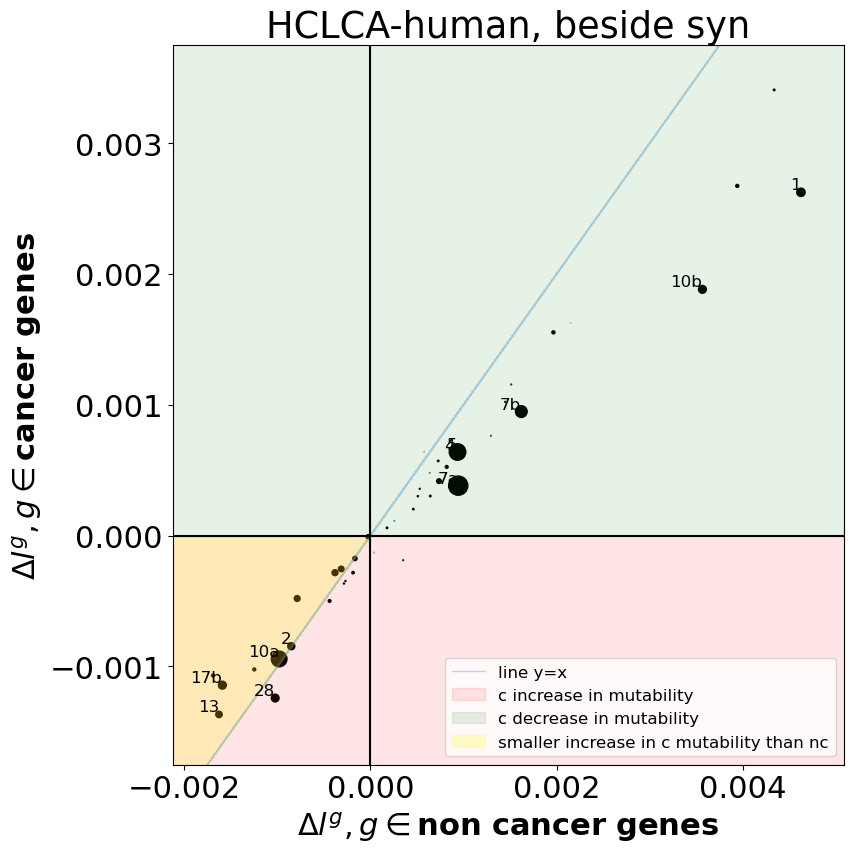

/tmp/ipykernel_2253663/4031908612.py:56: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sig_weights[i]>0.02:
/tmp/ipykernel_2253663/4031908612.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(x_axis[i], y_axis[i], sig[3:], fontsize=12, ha='right', va='bottom', alpha=1)


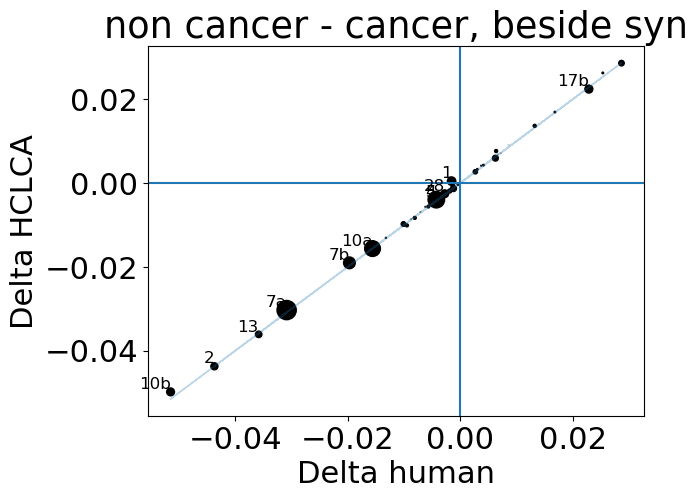

In [50]:
cancer_genes = '/home/maria/run_simulations/data/Cosmic_CancerGeneCensus_names.txt'
gene_ids = '/home/maria/cactus_target_size/auxillary/gene_name_id.csv'
weights_file = '/home/maria/data/signature_weights/calc_mut_weights.csv'

'''
homo_file = '/home/maria/cactus_target_size/output/chimp/'
HCLCA_file = '/home/maria/cactus_target_size/output/anc/'
title = 'HCLCA-human'
'''
HCLCA_file ='/home/maria/cactus_target_size/output_beside_syn/Anc4/'
homo_file ='/home/maria/cactus_target_size/output_beside_syn/hg38/'
title = 'HCLCA-human, beside syn'


gene_id_df = pd.read_csv(gene_ids)

cancer_genes_df = pd.read_csv(cancer_genes, names=['gene_name'])
#convert cancer genes to ensembl gene ids
cancer_id_df = cancer_genes_df.merge(gene_id_df, on=['gene_name'], how='inner')
cancer_genes_list = cancer_id_df['gene'].tolist()

human_df = extract_avg_l_per_sig(homo_file, 'human', cancer_genes_list)
HCLCA_df = extract_avg_l_per_sig(HCLCA_file, 'HCLCA', cancer_genes_list)
merged_df = human_df.join(HCLCA_df)

filtered_sum = pd.read_csv(weights_file, index_col=0, names=['norm_weight'])
weight_merged_df = merged_df.join(filtered_sum, how='inner')
weight_merged_df['c_Delta'] = (weight_merged_df['l_c_HCLCA']-weight_merged_df['l_c_human'])/( weight_merged_df['l_c_HCLCA']+weight_merged_df['l_c_human'])
weight_merged_df['nc_Delta'] = (weight_merged_df['l_nc_HCLCA']-weight_merged_df['l_nc_human'])/(weight_merged_df['l_nc_HCLCA']+weight_merged_df['l_nc_human'])


plt.figure(figsize=(9,9))
plot_c_diff_against_nc_diff(weight_merged_df['c_Delta'], weight_merged_df['nc_Delta'], weight_merged_df.index, weight_merged_df['norm_weight'], title)

signatures =weight_merged_df.index
sig_weights = weight_merged_df['norm_weight']
#x_axis = (weight_merged_df['l_nc_human']-weight_merged_df['l_c_human'])
#y_axis = (weight_merged_df['l_nc_HCLCA']-weight_merged_df['l_c_HCLCA'] )

x_axis = (weight_merged_df['l_nc_human']-weight_merged_df['l_c_human'])/(weight_merged_df['l_c_human'] + weight_merged_df['l_nc_human'])
y_axis = (weight_merged_df['l_nc_HCLCA']-weight_merged_df['l_c_HCLCA'] )/(weight_merged_df['l_c_HCLCA'] + weight_merged_df['l_nc_HCLCA'])

plt.figure()
plt.scatter(x_axis,y_axis, s=1000 * sig_weights, color='k', alpha=1)
plt.plot(x_axis, x_axis,linewidth=1, alpha =0.3, label = 'line y=x')
plt.axhline(y=0)
plt.axvline(x=0)
    # Labels
    #plt.rcParams['text.usetex'] = True
plt.xlabel('Delta human')
plt.ylabel('Delta HCLCA')
plt.title('non cancer - cancer, beside syn')

# Signature labels for most impt sigs
for i, sig in enumerate(signatures):
    if sig_weights[i]>0.02:
        plt.text(x_axis[i], y_axis[i], sig[3:], fontsize=12, ha='right', va='bottom', alpha=1)



In [70]:
#looking at correlations of target size with gc content
from scipy.stats import pearsonr
possible_species = ['hg38', 'Anc4', 'Anc3', 'Anc1', 'Anc0']

speci = 'hg38'
sig = 'SBS5'

df = pd.read_csv(f'/home/maria/cactus_target_size/auxillary/primate_genome_heuristics2/{speci}', index_col =0)
df['gc_prcnt'] = (df['C'] + df['G'])/(df['A'] + df['T']+df['C'] + df['G'])
df['M_n_prcnt'] = (df['M_n'])/(df['M_n'] + df['M_s'])
df['gc_4fold_prcnt'] = (df['syn_GC_ending'])/(df['syn_AT_ending'] + df['syn_GC_ending'])


homo_file =f'/home/maria/cactus_target_size/output_primates/hg38/l_SBS1'
sig_df1 = pd.read_csv(homo_file,index_col=0, names =['l_n1'])
homo_file =f'/home/maria/cactus_target_size/output_primates/hg38/l_SBS5'
sig_df5 = pd.read_csv(homo_file,index_col=0, names =['l_n5'])
sig_df = sig_df1.join(sig_df5, how='inner')
sig_df['l_n'] = sig_df['l_n1'] + 3*sig_df['l_n5']
df = sig_df.join(df, how='inner')
df_corr = df[['gc_prcnt', 'M_n_prcnt', 'gc_4fold_prcnt', 'l_n']]
corr = df_corr.corr(method = 'spearman')
print(corr)

# this computes the correlation coefficients
corr = df_corr.corr(method=lambda x, y: pearsonr(x, y)[0]) 
corr
# this computes the p-values
pvalues = df_corr.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(len(df_corr.columns)) 
pvalues

                         gc_prcnt          M_n_prcnt     gc_4fold_prcnt  \
gc_prcnt        1.000000000000000 -0.772403740021234  0.888766020094657   
M_n_prcnt      -0.772403740021234  1.000000000000000 -0.587935356892712   
gc_4fold_prcnt  0.888766020094657 -0.587935356892712  1.000000000000000   
l_n             0.878327222254952 -0.697787145212974  0.815979651630840   

                              l_n  
gc_prcnt        0.878327222254952  
M_n_prcnt      -0.697787145212974  
gc_4fold_prcnt  0.815979651630840  
l_n             1.000000000000000  


,gc_prcnt,M_n_prcnt,gc_4fold_prcnt,l_n
gc_prcnt,0.0,0.0,0.0,0.0
M_n_prcnt,0.0,0.0,0.0,0.0
gc_4fold_prcnt,0.0,0.0,0.0,0.0
l_n,0.0,0.0,0.0,0.0


/tmp/ipykernel_560648/4063450483.py:88: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if sig_weights[i]>0.02:
/tmp/ipykernel_560648/4063450483.py:93: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(nc_diff[i], c_diff[i], sig[3:], fontsize=12, ha='right', va='bottom', alpha=1)
/tmp/ipykernel_560648/4063450483.py:91: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(nc_diff[i])
/tmp/ipykernel_560648/4063450483.py:92: FutureWa

SBS10b
0.0021426754887826924
0.001825722392174313


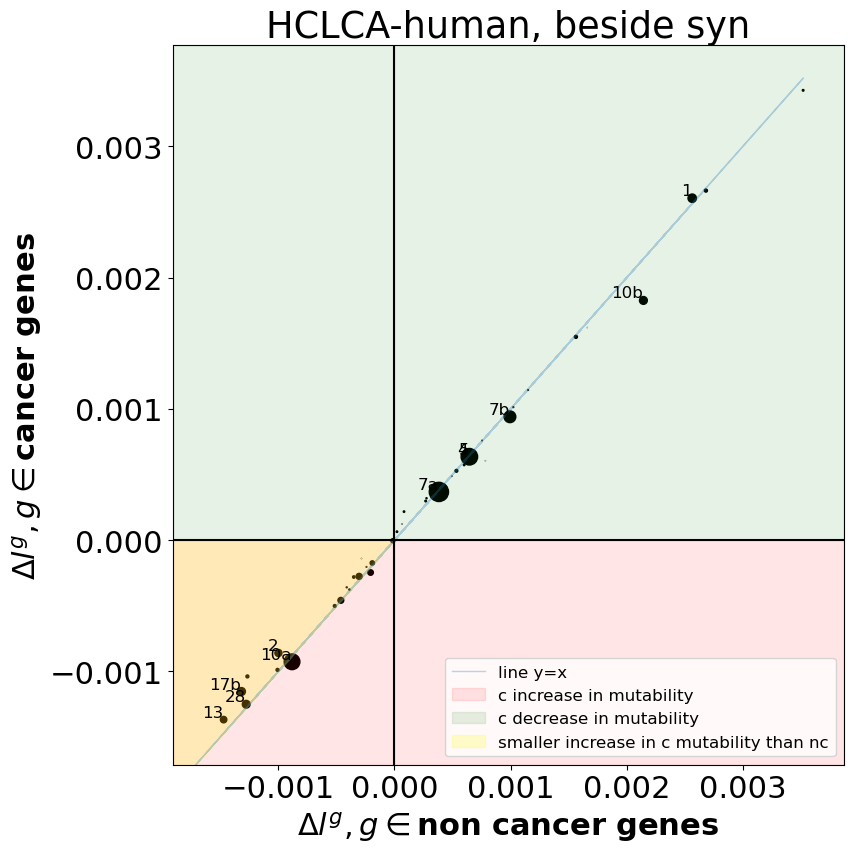

In [8]:
#redoing with matched cancer and non cancer genes:
matched_gene_file = '/home/maria/gene_matching/output/matched_genes.tsv'
matched_gene_df = pd.read_csv(matched_gene_file, index_col=0)

gene_dict = gene_id_df.set_index('gene')['gene_name'].to_dict()

human_df_match = extract_avg_l_per_sig_matched_genes(homo_file, 'human',  matched_gene_df, gene_dict)
HCLCA_df_match = extract_avg_l_per_sig_matched_genes(HCLCA_file, 'HCLCA',  matched_gene_df, gene_dict)

merged_df_match = human_df_match.join(HCLCA_df_match)

filtered_sum = pd.read_csv(weights_file, index_col=0, names=['norm_weight'])
weight_merged_df = merged_df_match.join(filtered_sum, how='inner')
weight_merged_df['c_Delta'] = (weight_merged_df['l_c_HCLCA']-weight_merged_df['l_c_human'])/( weight_merged_df['l_c_HCLCA']+weight_merged_df['l_c_human'])
weight_merged_df['nc_Delta'] = (weight_merged_df['l_nc_HCLCA']-weight_merged_df['l_nc_human'])/(weight_merged_df['l_nc_HCLCA']+weight_merged_df['l_nc_human'])


plt.figure(figsize=(9,9))
plot_c_diff_against_nc_diff(weight_merged_df['c_Delta'], weight_merged_df['nc_Delta'], weight_merged_df.index, weight_merged_df['norm_weight'], title)



In [43]:
#looking at strongest gemrline signature, unnormalised
homo_file = '/home/maria/cactus_target_size/output/hg38/'
HCLCA_file = '/home/maria/cactus_target_size/output/anc/'
MRCA_sig_df = extract_sigs_per_gene(HCLCA_file)
homo_sig_df = extract_sigs_per_gene(homo_file)

diff_df = MRCA_sig_df - homo_sig_df
diff_df=diff_df.rename(index=gene_dict)
diff_df['sum'] = diff_df['SBS1'] +3* diff_df['SBS5']
diff_df.sort_values(by='sum',inplace=True, ascending=False)
selected_germ_df = diff_df[diff_df['sum']> 0]
selected_germ_df['norm'] = selected_germ_df['sum']/selected_germ_df['sum'].sum()

selected_germ_df['norm'][:500].to_csv('/home/maria/cactus_target_size/output/gene_list_SBS1_3SBS5.bed', header=False)

diff_df.sort_values(by='SBS7b',inplace=True, ascending=False)
diff_df['SBS7b'][:500].to_csv('/home/maria/cactus_target_size/output/gene_list_SBS7b.bed', header=False)


/tmp/ipykernel_38441/213633192.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_germ_df['norm'] = selected_germ_df['sum']/selected_germ_df['sum'].sum()


In [72]:

#cactus
#chnage base species in extraction function!! hg38 vs homo spaiens
species_list = ["hg38", "Anc4","Anc3", "Anc1", "Anc0"]
base_species = 'hg38'
species_filepaths = {specie: f'/home/maria/cactus_target_size/output_primates/{specie}/' for specie in species_list}

'''
#ensembl data:
species_list = [ "HCGOrGib", "HCGOrLCA","HCGLCA",  "HCLCA", "homo_sapiens"]
species_list = species_list[::-1]
base_species = 'homo_sapiens'
species_filepaths = {specie: f'/home/maria/ensembl_fixed_method/output_primate/{specie}/' for specie in species_list}
'''
cancer_genes = '/home/maria/run_simulations/data/Cosmic_CancerGeneCensus_names.txt'
gene_ids = '/home/maria/cactus_target_size/auxillary/gene_name_id.csv'


#now extracting df only containing cancer genes
gene_id_df = pd.read_csv(gene_ids)
cancer_genes_df = pd.read_csv(cancer_genes, names=['gene_name'])
#convert cancer genes to ensembl gene ids
cancer_id_df = cancer_genes_df.merge(gene_id_df, on=['gene_name'], how='inner')
cancer_genes_list = set(cancer_id_df['gene'].tolist())

cancer_merged_df, cancer_sum_df = extract_df_per_species_gene_subset(species_filepaths, cancer_genes_list, 0, 1,'cancer',base_species)
#set subset ==0, so extract all genes but cancer genes
nc_merged_df, nc_sum_df = extract_df_per_species_gene_subset(species_filepaths, cancer_genes_list, 0, 0,'nc', base_species)




{'ENSG00000153012.12', 'ENSG00000204815.10', 'ENSG00000253293.6', 'ENSG00000114023.16', 'ENSG00000063169.12', 'ENSG00000037474.15', 'ENSG00000110851.12', 'ENSG00000131264.4', 'ENSG00000117862.14', 'ENSG00000088325.16', 'ENSG00000142039.4', 'ENSG00000113600.12', 'ENSG00000121964.15', 'ENSG00000148925.11', 'ENSG00000110934.13', 'ENSG00000127554.13', 'ENSG00000214360.5', 'ENSG00000167705.12', 'ENSG00000183378.13', 'ENSG00000198546.15', 'ENSG00000154274.15', 'ENSG00000137558.9', 'ENSG00000142784.16', 'ENSG00000138231.14', 'ENSG00000136010.14', 'ENSG00000167196.14', 'ENSG00000075891.24', 'ENSG00000042493.16', 'ENSG00000162614.19', 'ENSG00000221866.10', 'ENSG00000239642.6', 'ENSG00000274286.2', 'ENSG00000188428.20', 'ENSG00000160803.8', 'ENSG00000129467.14', 'ENSG00000205423.12', 'ENSG00000167964.13', 'ENSG00000154589.7', 'ENSG00000119686.10', 'ENSG00000115170.16', 'ENSG00000082126.18', 'ENSG00000065618.21', 'ENSG00000166033.13', 'ENSG00000185262.9', 'ENSG00000213654.10', 'ENSG00000130307.12

<>:37: SyntaxWarning: invalid escape sequence '\i'
<>:62: SyntaxWarning: invalid escape sequence '\i'
<>:37: SyntaxWarning: invalid escape sequence '\i'
<>:62: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_2253663/1063493719.py:37: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel('$l^g, g \in \mathbf{cancer\ genes}$ species/human', fontsize=16)
/tmp/ipykernel_2253663/1063493719.py:62: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel('$l^g, g \in \mathbf{cancer\ genes}$ species/human', fontsize=16)


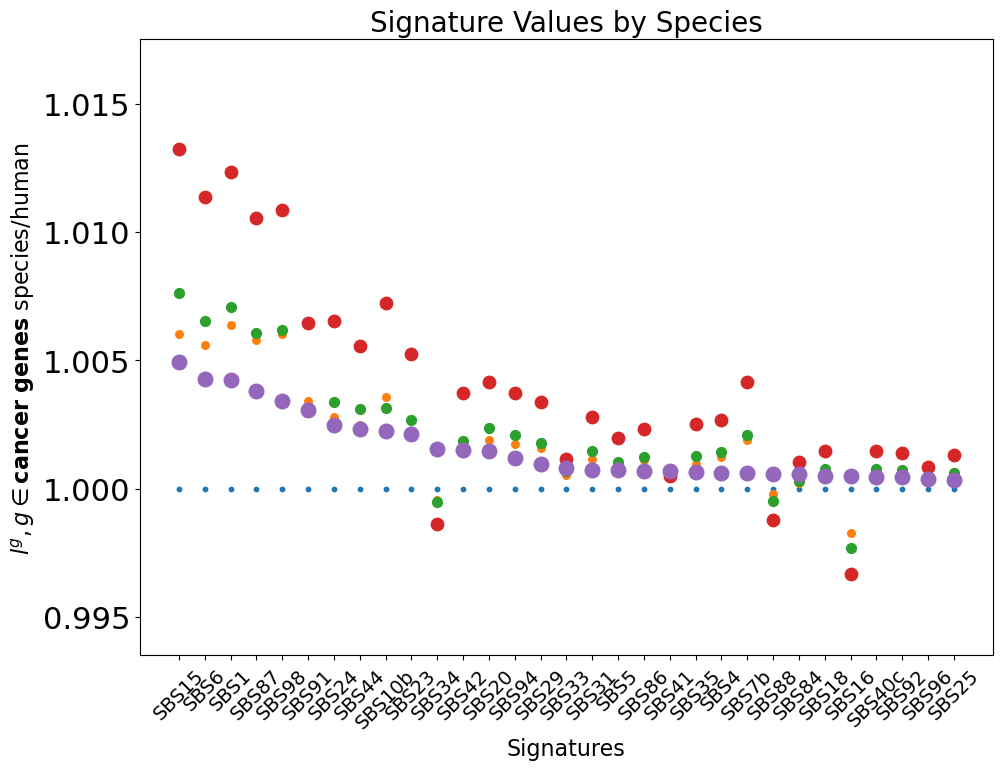

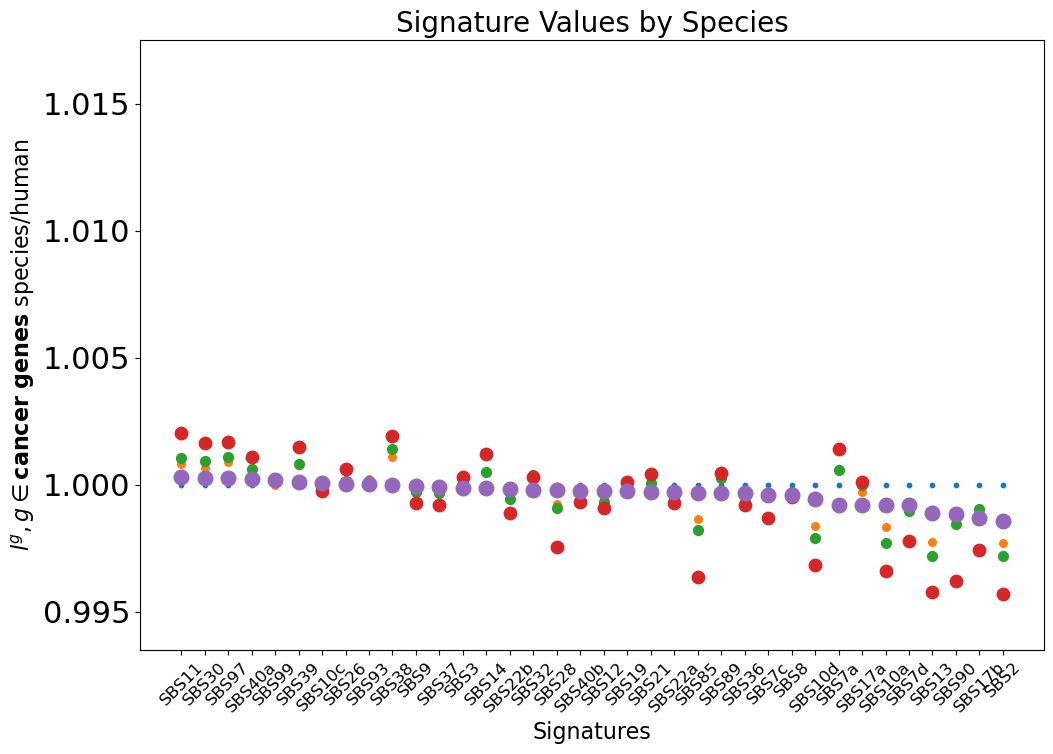

In [75]:
#plot to compare across primates

#plottin just cancer genes

df_T=cancer_merged_df.T
df=df_T
df = df_T.div(df_T.loc[f'l_{base_species}_cancer'])
sorted_cols = df.loc[f'l_{species_list[-1]}_cancer'].sort_values(ascending=False).index
df_sorted = df[sorted_cols]
df1 = df_sorted.iloc[:, :31]  #31
#df1 = df[['SBS1', 'SBS5']]
#df1 = df[['SBS1', 'SBS5', 'SBS18', 'SBS34', 'SBS40a', 'SBS40b', 'SBS40c']]

point_sizes = {
    'hg38': 10,
    'Anc4': 30,
    'Anc3': 50,
    'Anc1': 80,
    'Anc0': 110
}
'''
point_sizes = {
       'homo_sapiens': 10,
       'HCLCA': 30,
       'HCGLCA': 50,
       'HCGOrLCA': 80,
       'HCGOrGib': 110
       }
'''
plt.figure(figsize=(11, 8))
for species in species_list:
    size = point_sizes.get(species, 40)
  
    plt.scatter(df1.columns, df1.loc[f'l_{species}_cancer'], label=species, s = size)

plt.xlabel('Signatures', fontsize=16)
plt.ylabel('$l^g, g \in \mathbf{cancer\ genes}$ species/human', fontsize=16)
plt.title('Signature Values by Species', fontsize=20)
plt.xticks(rotation=45, fontsize=14)
#cactus
plt.ylim(0.9935, 1.0175)
#plt.ylim(0.995, 1.014)
#ensembl
#plt.ylim(0.9975,1.0025)
#plt.ylim(0.999, 1.001)
#plt.legend(title='Species')
#plt.tight_layout()
#plt.savefig(f'/home/maria/target_size_primates/output_graphs/primate_cancer1.svg', format='svg',bbox_inches='tight')
plt.show()


plt.figure(figsize=(11, 8))
df2 = df_sorted.iloc[:, 31:]
#df = df[['SBS1', 'SBS5', 'SBS2','SBS13','SBS6', 'SBS18', 'SBS4','SBS3', 'SBS40a', 'SBS40b', 'SBS40c', 'SBS7a', 'SBS90']]


for species in species_list:
    size = point_sizes.get(species, 40)
    plt.scatter(df2.columns, df2.loc[f'l_{species}_cancer'], label=species, s = size)

plt.xlabel('Signatures', fontsize=16)
plt.ylabel('$l^g, g \in \mathbf{cancer\ genes}$ species/human', fontsize=16)
plt.title('Signature Values by Species', fontsize=20)
plt.xticks(rotation=45,fontsize=12)

#cactus
plt.ylim(0.9935, 1.0175)
#ensembl
#plt.ylim(0.9975,1.0025)
#plt.legend(title='Species')
#plt.savefig(f'/home/maria/target_size_primates/output_graphs/primate_cancer2.svg', format='svg',bbox_inches='tight')
#plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<>:36: SyntaxWarning: invalid escape sequence '\i'
<>:61: SyntaxWarning: invalid escape sequence '\i'
<>:36: SyntaxWarning: invalid escape sequence '\i'
<>:61: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_2253663/757149633.py:36: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel('$l^g, g \in \mathbf{non cancer\ genes}$ species/human', fontsize=16)
/tmp/ipykernel_2253663/757149633.py:61: SyntaxWarning: invalid escape sequence '\i'
  plt.ylabel('$l^g, g \in \mathbf{non cancer\ genes}$ species/human', fontsize=16)


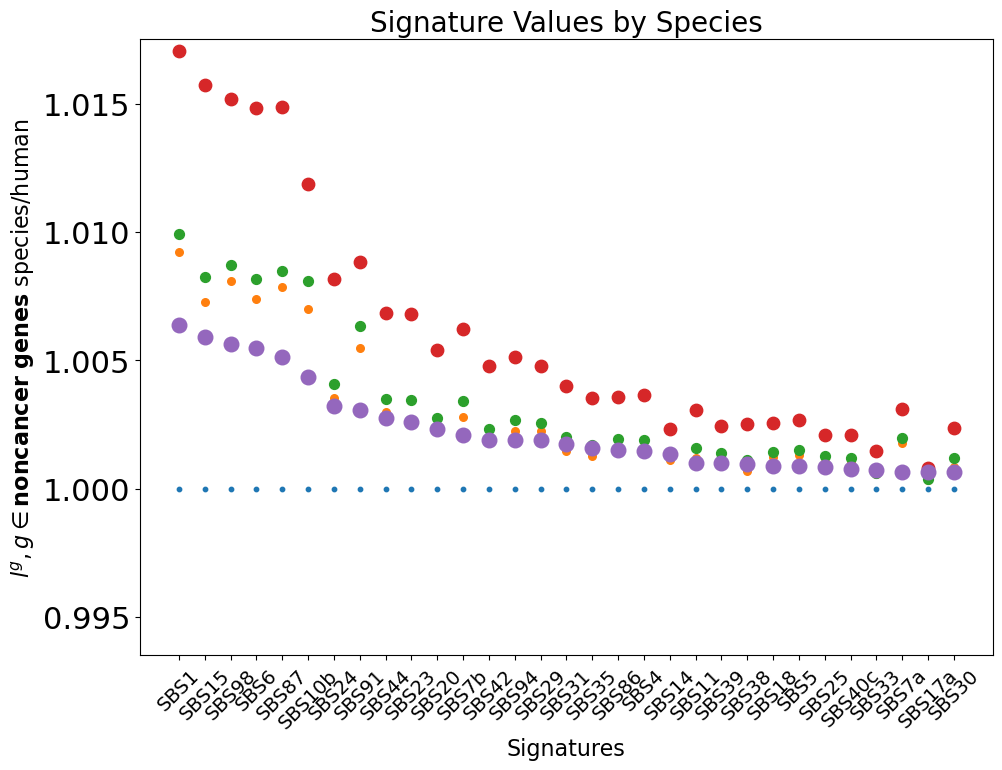

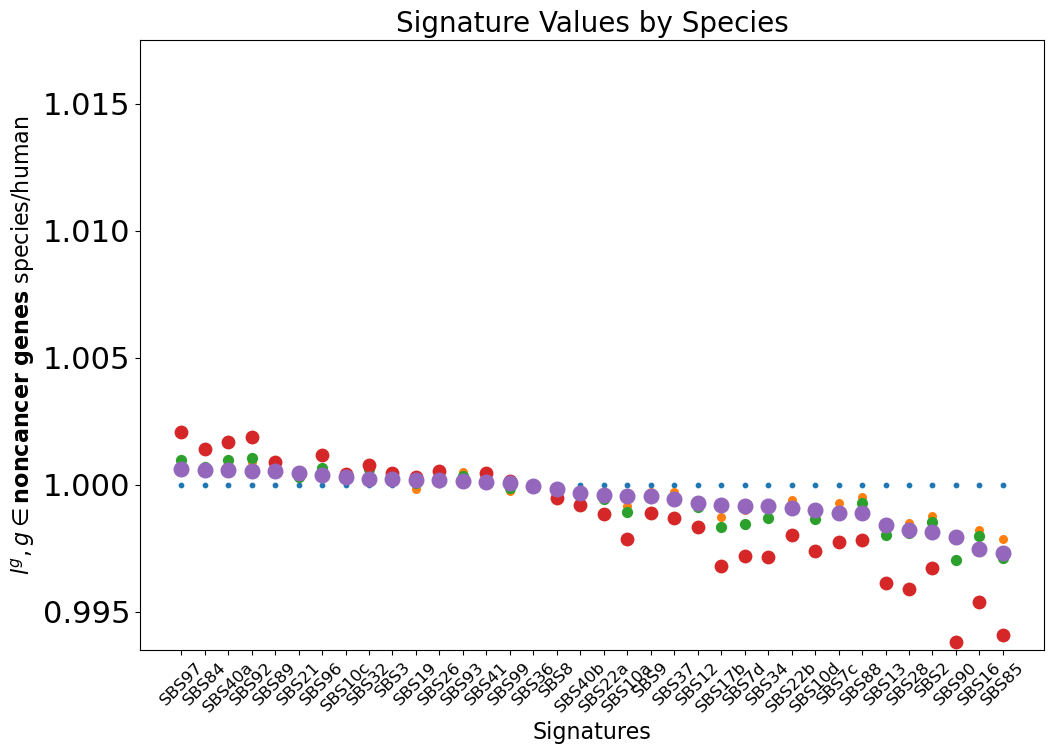

In [76]:
#plot to compare across primates
#plotting the non cancer genes to compare

df_T=nc_merged_df.T
df=df_T
df = df_T.div(df_T.loc[f'l_{base_species}_nc'])
sorted_cols = df.loc[f'l_{species_list[-1]}_nc'].sort_values(ascending=False).index
df_sorted = df[sorted_cols]
df1 = df_sorted.iloc[:, :31]  #31
#df1 = df[['SBS1', 'SBS5']]
#df1 = df[['SBS1', 'SBS5', 'SBS18', 'SBS34', 'SBS40a', 'SBS40b', 'SBS40c']]

point_sizes = {
    'hg38': 10,
    'Anc4': 30,
    'Anc3': 50,
    'Anc1': 80,
    'Anc0': 110
}
'''
point_sizes = {
       'homo_sapiens': 10,
       'HCLCA': 30,
       'HCGLCA': 50,
       'HCGOrLCA': 80,
       'HCGOrGib': 110
       }
'''
plt.figure(figsize=(11, 8))
for species in species_list:
    size = point_sizes.get(species, 40)
  
    plt.scatter(df1.columns, df1.loc[f'l_{species}_nc'], label=species, s = size)

plt.xlabel('Signatures', fontsize=16)
plt.ylabel('$l^g, g \in \mathbf{non cancer\ genes}$ species/human', fontsize=16)
plt.title('Signature Values by Species', fontsize=20)
plt.xticks(rotation=45, fontsize=14)
#cactus
plt.ylim(0.9935, 1.0175)
#plt.ylim(0.9925, 1.0175)
#ensembl
#plt.ylim(0.9975,1.0025)
#plt.ylim(0.999, 1.001)
#plt.legend(title='Species')
#plt.tight_layout()
#plt.savefig(f'/home/maria/target_size_primates/output_graphs/primate_cancer1.svg', format='svg',bbox_inches='tight')
plt.show()


plt.figure(figsize=(11, 8))
df2 = df_sorted.iloc[:, 31:]
#df = df[['SBS1', 'SBS5', 'SBS2','SBS13','SBS6', 'SBS18', 'SBS4','SBS3', 'SBS40a', 'SBS40b', 'SBS40c', 'SBS7a', 'SBS90']]


for species in species_list:
    size = point_sizes.get(species, 40)
    plt.scatter(df2.columns, df2.loc[f'l_{species}_nc'], label=species, s = size)

plt.xlabel('Signatures', fontsize=16)
plt.ylabel('$l^g, g \in \mathbf{non cancer\ genes}$ species/human', fontsize=16)
plt.title('Signature Values by Species', fontsize=20)
plt.xticks(rotation=45,fontsize=12)

#cactus
plt.ylim(0.9935, 1.0175)
#plt.ylim(0.9925, 1.0175)
#ensembl
#plt.ylim(0.9975,1.0025)
#plt.legend(title='Species')
#plt.savefig(f'/home/maria/target_size_primates/output_graphs/primate_cancer2.svg', format='svg',bbox_inches='tight')
#plt.legend(title='Species', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

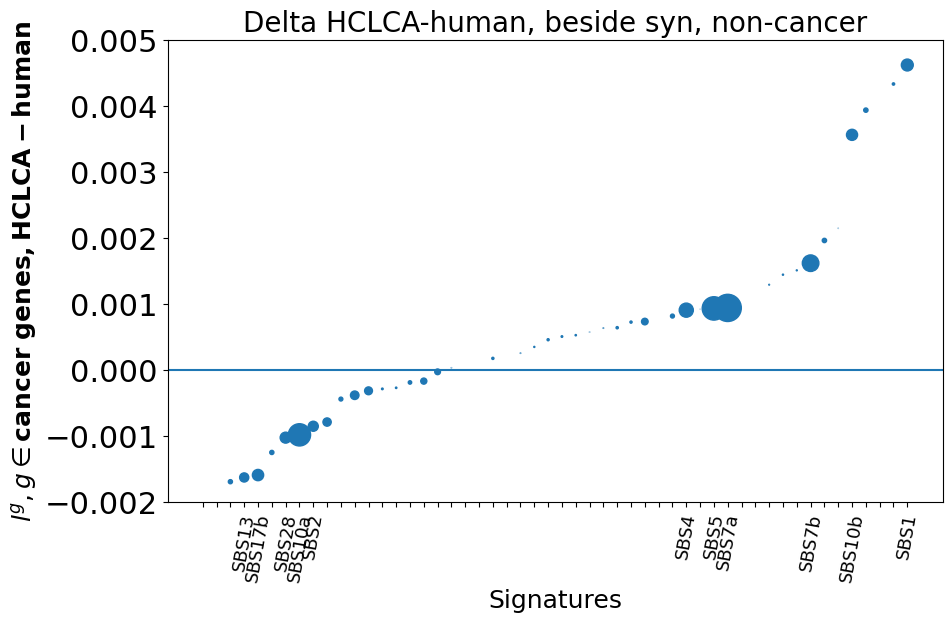

In [ ]:
#need to account for differing content 


#plotting chnage in cancer genes, to compare to beside synonymous sites
cancer_genes = '/home/maria/run_simulations/data/Cosmic_CancerGeneCensus_names.txt'
gene_ids = '/home/maria/cactus_target_size/auxillary/gene_name_id.csv'
weights_file = '/home/maria/data/signature_weights/calc_mut_weights.csv'
'''
homo_file = '/home/maria/cactus_target_size/output/chimp/'
HCLCA_file = '/home/maria/cactus_target_size/output/anc/'
title = 'Delta HCLCA-human, all sites, non-cancer'
'''
HCLCA_file ='/home/maria/cactus_target_size/output_beside_syn/Anc4/'
homo_file ='/home/maria/cactus_target_size/output_beside_syn/hg38/'
title = 'Delta HCLCA-human, beside syn, non-cancer'

gene_id_df = pd.read_csv(gene_ids)

cancer_genes_df = pd.read_csv(cancer_genes, names=['gene_name'])
#convert cancer genes to ensembl gene ids
cancer_id_df = cancer_genes_df.merge(gene_id_df, on=['gene_name'], how='inner')
cancer_genes_list = cancer_id_df['gene'].tolist()

human_df = extract_avg_l_per_sig(homo_file, 'human', cancer_genes_list)
HCLCA_df = extract_avg_l_per_sig(HCLCA_file, 'HCLCA', cancer_genes_list)
merged_df = human_df.join(HCLCA_df)

filtered_sum = pd.read_csv(weights_file, index_col=0, names=['norm_weight'])
weight_merged_df = merged_df.join(filtered_sum, how='inner')

weight_merged_df['diff'] = (weight_merged_df['l_c_HCLCA']- weight_merged_df['l_c_human'])

weight_merged_df['diff'] = (weight_merged_df['l_nc_HCLCA']- weight_merged_df['l_nc_human'])/(weight_merged_df['l_nc_HCLCA']+ weight_merged_df['l_nc_human'])
weight_merged_df.sort_values('diff', ascending =True, inplace=True)

plt.figure()

plot_change_against_sig_weighted(weight_merged_df['diff'], weight_merged_df.index, weight_merged_df['norm_weight'], title)
